## A/B тест

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2025-03-28 по 2025-04-03 включительно. Для эксперимента были задействованы 2 и 1 группы. 

- В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

- Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib

from scipy import stats
%matplotlib inline

In [2]:
# Подключение к базе
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250420'
}

In [20]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250420.feed_actions
WHERE toDate(time) between '2025-03-28' and '2025-04-03'
    and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()


,user_id,likes,views,ctr
exp_group,,,,
0,9920,9920,9920,9920
1,10020,10020,10020,10020
2,9877,9877,9877,9877
3,10002,10002,10002,10002


In [21]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,12,44,0.272727
1,1,18392,7,32,0.218750
2,3,123580,2,11,0.181818
3,2,131473,9,108,0.083333
4,2,32420,13,44,0.295455


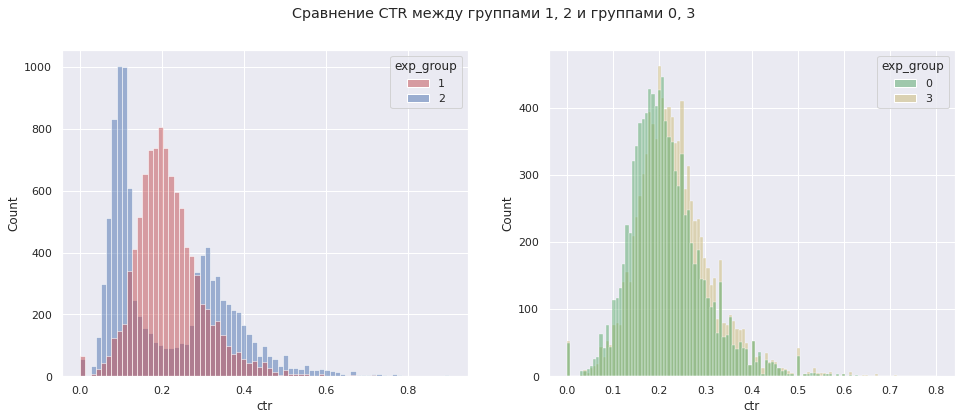

In [22]:
# Сделаем графики в seaborn
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set(rc={'figure.figsize':(16,6)})
groups = sns.histplot(data=df[df['exp_group'].isin([1,2])], 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False, ax=axes[0])

groups = sns.histplot(data=df[df['exp_group'].isin([0,3])], 
              x='ctr', 
              hue='exp_group', 
              palette = ['g', 'y'],
              alpha=0.5,
              kde=False,
              ax=axes[1])

plt.suptitle('Сравнение CTR между группами 1, 2 и группами 0, 3');

In [23]:
#посмотрим значение p-value по t-тесту (Тесту Стьюдента) по метрике ctr для группы 0 и 3
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

In [24]:
#посмотрим значене p-value по тесту Манна-Уитни по метрике ctr для группы 0 и 3
stats.mannwhitneyu(df[df.exp_group == 0].ctr, 
                   df[df.exp_group == 3].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43165459.5, pvalue=8.916679404235955e-57)

In [25]:
#посмотрим значение p-value по t-тесту (Тесту Стьюдента) по метрике ctr для группы 1 и 2
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

In [26]:
#посмотрим значене p-value по тесту Манна-Уитни по метрике ctr для группы 1 и 2
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

1. При анализе A/B теста в групппах 0 и 3 распределение выглядит нормальным (одним пиком), и p-value в t-тесте и тесте Манна-Уитни по метрике CTR очень маленькое (близкое к нулю), отсюда можно сделать вывод, что статистически значимое различие между группой 0 и группой 3 есть.

2. Распределение метрики в группе 2 бимодальное (двугорбое), а в группе 1 распределение выглядит более нормальным (одним пиком), это может указывать на наличие двух различных подгрупп пользователей в группе 2. Из-за двугорбого распределения в группе 2 результаты t-критерия Стьюдента могут быть менее надежными, и это может привести к некорректным выводам.

Результаты теста Манна-Уитни указывают на наличие статистически значимых различий между группами или выборками, которые были сравнены. Значение pvalue=4.632205841806026e-45 очень близко к нулю (практически нулевое), что указывает на высокую степень статистической значимости.

In [27]:
# находим общий CTR в контрольных группах
ctr_control_0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum() #в группе 0-3
ctr_control_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum() #в группе 1-2

In [28]:
def get_lenearized_likes(user_likes, user_views, ctr_control):
    len_likes = user_likes - ctr_control * user_views
    return len_likes

In [29]:
#в группах 0 и 3 считаем поюзерную метрику линеаризованных лайков
group0 = df[df.exp_group == 0].copy()
group3 = df[df.exp_group == 3].copy()
group0['len_likes'] = df.apply(lambda x: get_lenearized_likes(x['likes'], x['views'], ctr_control_0), axis=1)
group3['len_likes'] = df.apply(lambda x: get_lenearized_likes(x['likes'], x['views'], ctr_control_0), axis=1)

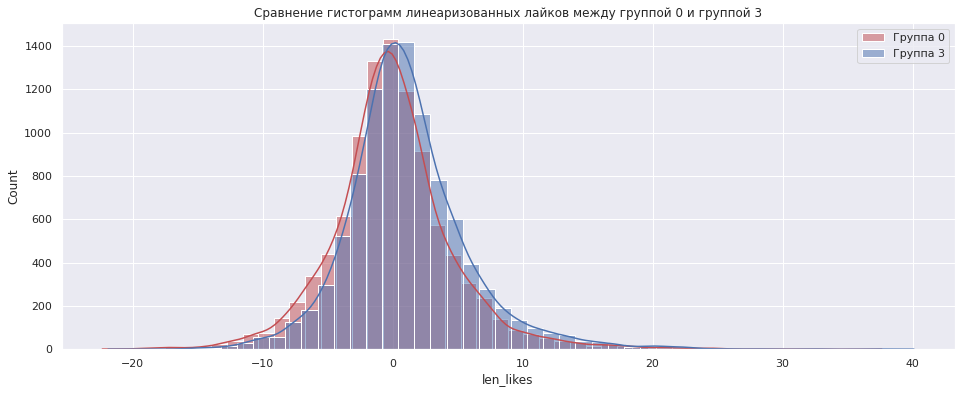

In [30]:
# Строим гистограмму для группы 0 и группы 3
sns.histplot(data=group0, x='len_likes', bins=50, kde=True, color='r', label='Группа 0')
sns.histplot(data=group3, x='len_likes', bins=50, kde=True, color='b', label='Группа 3')

plt.title('Сравнение гистограмм линеаризованных лайков между группой 0 и группой 3')
plt.legend()
plt.show()

На гистограмме линеаризованных лайков заметны различия между группой 0 и группой 3.

In [31]:
#значение p value по тесту Манна-Уитни
stats.mannwhitneyu(group0['len_likes'], 
                   group3['len_likes'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=42681950.0, pvalue=2.504376811309453e-65)

In [32]:
#значение p value по t-тесту
stats.ttest_ind(group0['len_likes'], 
                group3['len_likes'],
                equal_var=False)

Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)

В t-тесте и тесте Манна-Уитни p-value линеаризованных лайков очень маленькое (близкое к нулю), и таким образом подтверждается статистически значимое различие между группой 0 и группой 3.

In [33]:
#в группах 1 и 2 считаем поюзерную метрику линеаризованных лайков
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()
group1['len_likes'] = df.apply(lambda x: get_lenearized_likes(x['likes'], x['views'], ctr_control_1), axis=1)
group2['len_likes'] = df.apply(lambda x: get_lenearized_likes(x['likes'], x['views'], ctr_control_1), axis=1)

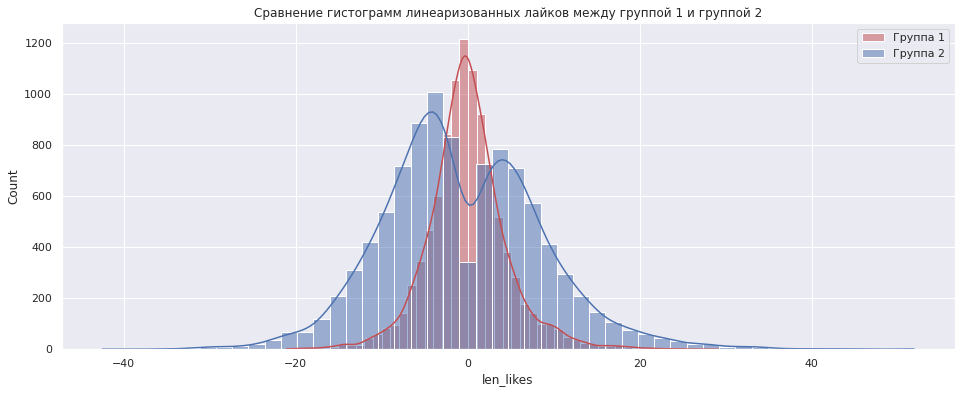

In [34]:
# Строим гистограмму для группы 0 и группы 3
sns.histplot(data=group1, x='len_likes', bins=50, kde=True, color='r', label='Группа 1')
sns.histplot(data=group2, x='len_likes', bins=50, kde=True, color='b', label='Группа 2')

plt.title('Сравнение гистограмм линеаризованных лайков между группой 1 и группой 2')
plt.legend()
plt.show()

На гистограмме линеаризованных лайков заметны различия между группой 1 и группой 2.

In [35]:
#значение p value по тесту Манна-Уитни
stats.mannwhitneyu(group1['len_likes'], 
                   group2['len_likes'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=53516442.5, pvalue=2.4030320776345276e-23)

In [36]:
#значение p value по t-тесту
stats.ttest_ind(group1['len_likes'], 
                group2['len_likes'],
                equal_var=False)

Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)

В t-тесте и тесте Манна-Уитни p-value линеаризованных лайков очень маленькое (близкое к нулю), и таким образом подтверждается статистически значимое различие между группой 1 и группой 2.

### Вывод:

1. p-value в t-тесте и тесте Манна-Уитни по метрике линеаризованных лайков в группе 0 и 3 стало еще меньше и так же близкое к нулю, что подтверждает статистически значимое различие между группой 0 и группой 3.
2. p-value в t-тесте по метрике линеаризованных лайков в группе 1 и 2 стало меньше (с 0.685373331140751 до 2.9805064038668383e-09), и теперь подтверждает статистически значимое различие между группой 1 и группой 2, а в тесте Манна-Уитни p-value стало чуть больше (с 4.632205841806026e-45 до 2.4030320776345276e-23), но так же близкое к нулю, что все равно подтверждает статистически значимое различие между группой 1 и группой 2